In [1]:
from dataclasses import dataclass, field
from typing import Optional
import sys
sys.path.append('/scratch/2023-fall-sp-le/langseg')

import torch
from torch import nn
from torch.nn import functional as F
torch.backends.cuda.matmul.allow_tf32 = True
from transformers import CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline

import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
from methods.prompt_engineering import extract_class_embeddings, extract_clip_text_embeddings
BICUBIC = InterpolationMode.BICUBIC

from datasets.coco_stuff import coco_stuff_categories
from datasets.cityscapes import cat_to_label_id as cityscapes_cats
from datasets.utils import get_dataset
from utils.metrics import RunningScore
from utils.plotting import *

from methods.diffusion_patch import *
from methods.diffusion import *
from methods.diffusion_seg import *
from methods.diffusion_utils import *
from methods.text_embeddings import *
from methods.multilabel_classifiers import *
from methods.exp_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
# @dataclass
# class SegmentationConfig:
#     dir_dataset: str = field(
#         default="/sinergia/ozaydin/segment/STEGO-master/data/cocostuff", metadata={"help": "dir dataset"}
#     )
#     dataset_name: str = field(
#         default="voc2012", metadata={"help": "for get_dataset"}
#     )
#     split: str = field(
#         default="train", metadata={"help": "which split to use"}
#     )
#     resolution: int = field(
#         default=512, metadata={"help": "resolution of the images, e.g, 512, 768, 1024"}
#     )
#     mask_res: int = field(
#         default=512, metadata={"help": "resolution of the masks, e.g, 64, 320, 512"}
#     )
#     dense_clip_arch: str = field(
#         default="RN50x16", metadata={"help": "not used in cocostuff"}
#     )

# args = SegmentationConfig()

@dataclass
class SegmentationConfig:
    dir_dataset: str = field(
        default="/scratch/2023-fall-sp-le/data/VOCdevkit/VOC2010", metadata={"help": "dir dataset"}
    )
    dataset_name: str = field(
        default="pascal_context", metadata={"help": "for get_dataset"}
    )
    split: str = field(
        default="train", metadata={"help": "which split to use"}
    )
    resolution: int = field(
        default=512, metadata={"help": "resolution of the images, e.g, 512, 768, 1024"}
    )
    mask_res: int = field(
        default=512, metadata={"help": "resolution of the masks, e.g, 64, 320, 512"}
    )
    dense_clip_arch: str = field(
        default="RN50x16", metadata={"help": "not used in cocostuff"}
    )

args = SegmentationConfig()

In [3]:
dataset, categories, palette = get_dataset(
    dir_dataset=args.dir_dataset,
    dataset_name=args.dataset_name,
    split=args.split,
    resolution=args.resolution,
    mask_res=args.mask_res,
    dense_clip_arch=args.dense_clip_arch
)

if args.dataset_name == "coco_stuff":
    label_id_to_cat = categories if not dataset.use_27 else coco_stuff_categories
    cat_to_label_id = {v: i for i, v in enumerate(label_id_to_cat)}
elif args.dataset_name == "cityscapes":
    cat_to_label_id = cityscapes_cats
    label_id_to_cat = {i: c for c, i in cat_to_label_id.items()}
elif args.dataset_name == "voc2012" or args.dataset_name == "pascal_context":
    label_id_to_cat = categories
    cat_to_label_id = {v: i for i, v in enumerate(label_id_to_cat)}

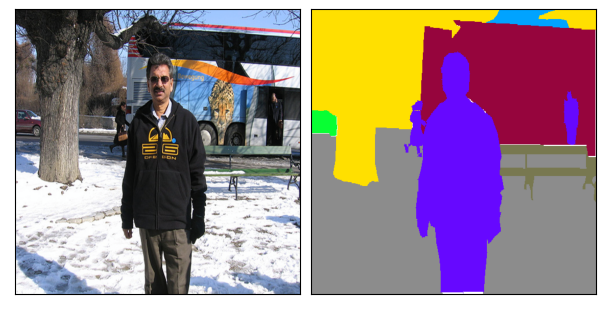

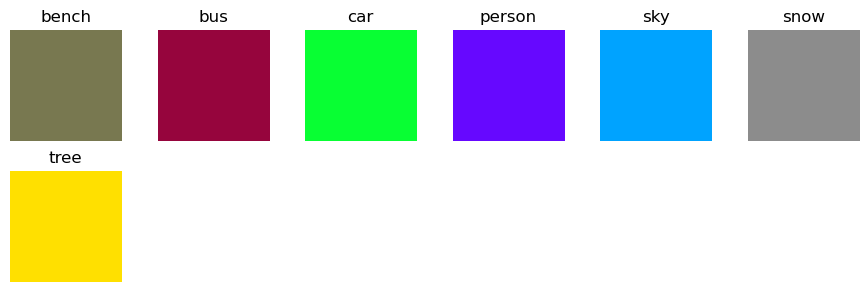

In [4]:
idx = 58
val_img = dataset[idx]["img"].cpu().numpy()
val_gt = dataset[idx]["gt"].cpu().numpy()
lab_ids = sorted(list(np.unique(val_gt)))
lab_ids = np.array(lab_ids[1:])
val_pil_img = render_results(val_img, val_gt, palette)
_ = get_legends(lab_ids, palette, label_id_to_cat, is_voc2012 = args.dataset_name == "voc2012")

In [5]:
import torch
from methods import gem
import requests
from PIL import Image

# model_name = 'ViT-B/16'  # 'ViT-B-16-quickgelu'
# pretrained = 'openai'  # 'metaclip_400m'
model_name = 'ViT-B/16-quickgelu'
# model_name = 'ViT-L/14-quickgelu'
pretrained = 'metaclip_400m'
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# init model and image transform
gem_model = gem.create_gem_model(model_name=model_name,
                                 pretrained=pretrained, 
                                 device=device)

In [6]:
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16,
    use_safetensors=True, variant="fp16",
    # device_map="auto"
)
pipe = pipe.to("cuda")
configure_ldm(pipe)

handles = {}
attention_layers_to_use = ATTENTION_LAYERS
attention_store = AttentionStore(low_resource=False, no_uncond=True, layer_keys=attention_layers_to_use)
attention_store.num_att_layers = len(attention_layers_to_use)
handles = register_attention_hooks(pipe.unet, attention_store, attention_layers_to_use, handles)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [7]:
def predict_voc(idx):
    preprocess = gem.get_gem_img_transform(img_size=(448, 448))

    val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
    val_gt = dataset[idx]["gt"].unsqueeze(0)
    val_labels = sorted(np.unique(val_gt))
    val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
    val_labels = [label_id_to_cat[c] for c in val_labels]
    val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input

    image = preprocess(Image.open(dataset[idx]["p_img"]).convert("RGB")).unsqueeze(0).to(device)
    class_names = label_id_to_cat[1:]

    with torch.no_grad():
        logits01 = gem_model(image, class_names, output_size=64, normalize=False)  # [1, num_class, W, H]
    # CA only
    logits23456 = F.interpolate(logits01, size=args.mask_res, mode='bilinear')
    logits23456 = get_voc2012_probs(logits23456)
    pred2 = logits23456.argmax(dim=1)
    pred3 = filter_prompt(logits23456, ["background"]+val_labels, cat_to_label_id).argmax(dim=1)
    pred4 = label_clusters(val_gt, logits23456)

    # CA @ SA
    val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
    attention_store.reset()
    text_embeds = get_text_embeddings_simple(pipe.tokenizer, pipe.text_encoder, "")
    val_img = val_img.repeat(len(text_embeds), axis=0)
    training_step(pipe, text_embeds, val_img, attention_store, no_uncond=True, normalize=False, low_resource=False, timestep=100)
    ca, sa = get_attention_maps(
        attention_store.get_average_attention(),
        batch_size=len(text_embeds),
        label_indices=None,
        output_size=64,
        average_layers=True,
        apply_softmax=True,
        softmax_dim=-1,
        simple_average=False
    )
    pred5 = diffseg(sa, out_res=args.mask_res, refine=True)
    pred5 = label_clusters(pred5, logits23456)
    pred6 = get_specclust_mask(
        logits23456.permute(0, 2, 3, 1).view(1, -1, logits23456.shape[1]), sa, cat_to_label_id,
        list(range(len(label_id_to_cat))), label_id_to_cat,
        output_size=args.mask_res, minmax_norm=False
    ).long()

    ca0 = get_voc2012_probs(logits01)
    ca0 = ca0.view(*ca0.shape[:2], -1).permute(0, 2, 1)
    agg_map0 = get_agg_map(ca0, sa, minmax_norm=False, ca_norm=False)
    agg_map0 = upscale_attn(agg_map0, args.mask_res)
    pred0 = agg_map0.argmax(dim=-1)

    ca1 = get_voc2012_probs(logits01)
    ca1 = ca1.view(*ca1.shape[:2], -1).permute(0, 2, 1)
    agg_map1 = get_agg_map(ca1, sa, minmax_norm=False, ca_norm=False)
    N, C, H, W = logits01.shape
    agg_map1 = filter_prompt(
        agg_map1.permute(0, 2, 1).view(N, C+1, H, W), ["background"]+val_labels, cat_to_label_id
    ).permute(0, 2, 3, 1).view_as(agg_map1)
    agg_map1 = upscale_attn(agg_map1, args.mask_res)
    pred1 = agg_map1.argmax(dim=-1)
    
    retvals = {
        "AggGEM": pred0.view(args.mask_res, args.mask_res).cpu().numpy(),
        "GEM": pred2.view(args.mask_res, args.mask_res).cpu().numpy(),
        "DiffSegClust": pred5.view(args.mask_res, args.mask_res).cpu().numpy(),
        "SpecClust": pred6.view(args.mask_res, args.mask_res).cpu().numpy(),
    }
    
    return retvals

In [15]:
def predict_context(idx):
    preprocess = gem.get_gem_img_transform(img_size=(448, 448))
    val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
    val_gt = dataset[idx]["gt"].unsqueeze(0)
    val_labels = sorted(np.unique(val_gt))
    val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
    val_labels = [label_id_to_cat[c] for c in val_labels]
    val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input

    # # multilabel classification (does not work)
    # image, y_true = get_image_and_labels(idx)
    # y_pred, _ = clip_classifier.forward_v2(image, choice=(8,8), clf_thresh=0.25)
    # y_pred = y_pred.cpu().numpy()
    # val_labels = get_pred_label_names(y_pred, label_id_to_cat)

    # load image and text
    image = preprocess(Image.open(dataset[idx]["p_img"]).convert("RGB")).unsqueeze(0).to(device)
    class_names = label_id_to_cat

    with torch.no_grad():
        logits01 = gem_model(image, class_names, output_size=64, normalize=False)  # [1, num_class, W, H]

    # CA only
    logits23456 = F.interpolate(logits01, size=args.mask_res, mode='bilinear')
    logits23456 = (logits23456*100).softmax(dim=1)
    pred2 = logits23456.argmax(dim=1)
    pred3 = filter_prompt(logits23456, val_labels, cat_to_label_id).argmax(dim=1)
    pred4 = label_clusters(val_gt, logits23456)

    # CA @ SA
    val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
    attention_store.reset()
    text_embeds = get_text_embeddings_simple(pipe.tokenizer, pipe.text_encoder, "")
    val_img = val_img.repeat(len(text_embeds), axis=0)
    training_step(pipe, text_embeds, val_img, attention_store, no_uncond=True, normalize=False, low_resource=False, timestep=100)
    ca, sa = get_attention_maps(
        attention_store.get_average_attention(),
        batch_size=len(text_embeds),
        label_indices=None,
        output_size=64,
        average_layers=True,
        apply_softmax=True,
        softmax_dim=-1,
        simple_average=False
    )
    pred5 = diffseg(sa, out_res=args.mask_res, refine=True)
    pred5 = label_clusters(pred5, logits23456)
    pred6 = get_specclust_mask(
        logits23456.permute(0, 2, 3, 1).view(1, -1, logits23456.shape[1]), sa, cat_to_label_id,
        list(range(len(label_id_to_cat))), label_id_to_cat,
        output_size=args.mask_res, minmax_norm=False
    ).long()

    ca0 = (logits01 * 100).softmax(dim=1)
    ca0 = ca0.view(*ca0.shape[:2], -1).permute(0, 2, 1)
    agg_map0 = get_agg_map(ca0, sa, minmax_norm=False, ca_norm=False)
    agg_map0 = upscale_attn(agg_map0, args.mask_res)
    pred0 = agg_map0.argmax(dim=-1)

    ca1 = (filter_prompt(logits01, val_labels, cat_to_label_id) * 100).softmax(dim=1)
    ca1 = ca1.view(*ca1.shape[:2], -1).permute(0, 2, 1)
    agg_map1 = get_agg_map(ca1, sa, minmax_norm=False, ca_norm=False)
    agg_map1 = upscale_attn(agg_map1, args.mask_res)
    pred1 = agg_map1.argmax(dim=-1)

    retvals = {
        "AggGEM": pred0.view(args.mask_res, args.mask_res).cpu().numpy(),
        "GEM": pred2.view(args.mask_res, args.mask_res).cpu().numpy(),
        "DiffSegClust": pred5.view(args.mask_res, args.mask_res).cpu().numpy(),
        "SpecClust": pred6.view(args.mask_res, args.mask_res).cpu().numpy(),
    }
    
    return retvals

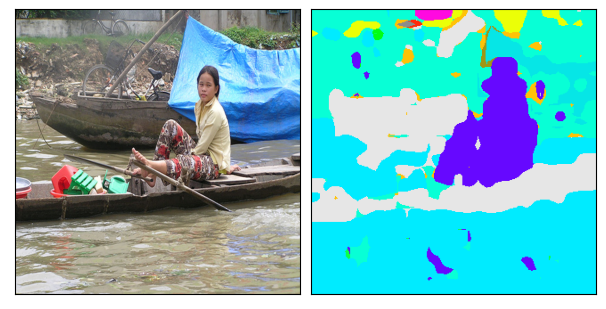

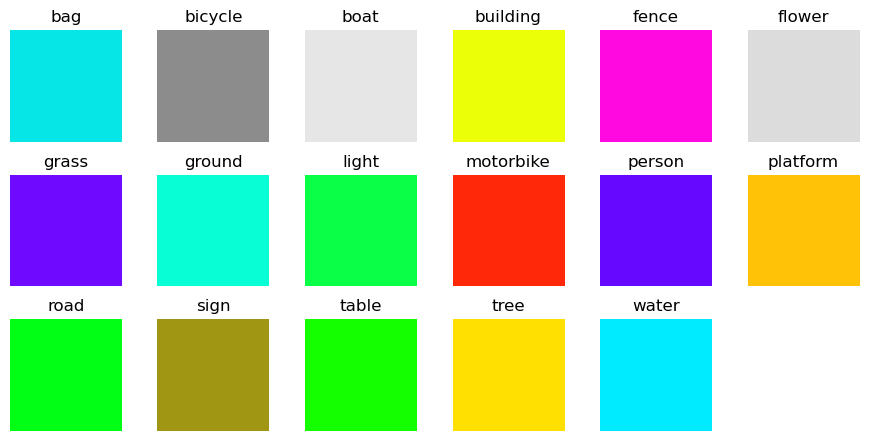

In [37]:
idx = 6
val_img = dataset[idx]["img"].cpu().numpy()
val_gt = dataset[idx]["gt"].cpu().numpy()
preds = predict_context(idx)
preds["GT"] = val_gt

_ = render_results(val_img, preds["GEM"], palette)

lab_ids = []
for k, v in preds.items():
    pred_ids = np.unique(v).tolist()
    pred_ids = [i for i in pred_ids if i != -1]
    lab_ids.extend(pred_ids)
lab_ids = np.unique(lab_ids)

_ = get_legends(lab_ids, palette, label_id_to_cat, is_voc2012 = args.dataset_name == "voc2012")

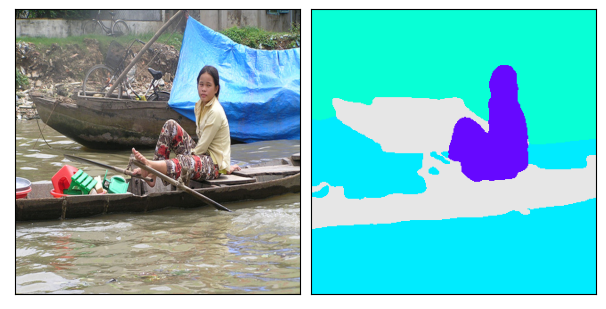

In [42]:
_ = render_results(val_img, preds["DiffSegClust"], palette)

In [ ]:
# 2, 3, 4, 10, 12, 69 for VOC2012
# 0, 2, 4, 6,  12, 69 for Context

In [16]:
val_imgs = []
preds = []
# indices = [2, 3, 4, 10, 12, 69]
indices = [0, 2, 4, 6,  12, 69]
for i in indices:
    val_imgs.append(Image.open(dataset[i]["p_img"]).convert("RGB").resize((512,512)))
    p = predict_context(i)
    p["GT"] = dataset[i]["gt"].cpu().numpy()
    preds.append(p)

all_preds = {}
names = preds[0].keys()
for n in names:
    all_preds[n] = [p[n] for p in preds]

In [20]:
def render_multiple(val_imgs, preds: dict, palette):
    # pred is a dict of {"name": [pred per image]}

    nrows, ncols = len(preds)+1, len(val_imgs)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.25, nrows*1.25))
    
    for j, val_img in enumerate(val_imgs):
        if j == 0:
            ax[0, j].set_ylabel("Image")
        ax[0, j].imshow(val_img)
        ax[0, j].set_xticks([])
        ax[0, j].set_yticks([])

    for i, (name, pred) in enumerate(preds.items()):
        i = i + 1
        for j, (val_img, val_pred) in enumerate(zip(val_imgs, pred)):
            val_pred = colourise_label(val_pred, palette, -1)
            if j == 0:
                ax[i, j].set_ylabel(name)
            ax[i, j].imshow(val_img)
            ax[i, j].imshow(val_pred, alpha=0.8)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    # plt.tight_layout()
    return fig

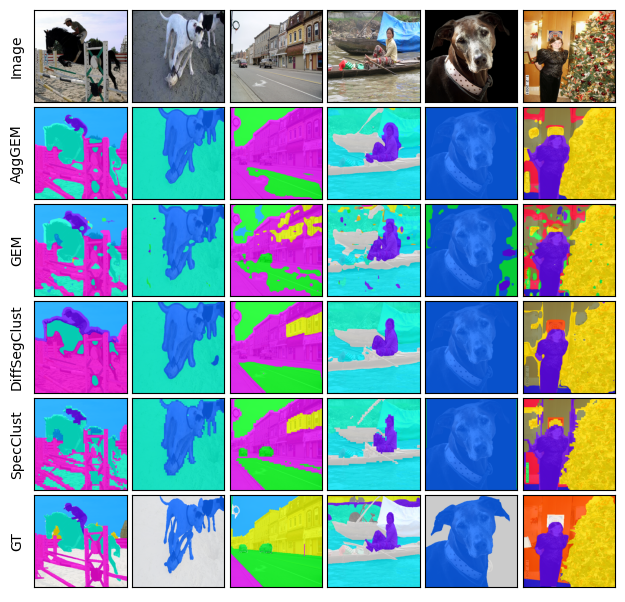

In [21]:
fig = render_multiple(val_imgs, all_preds, palette)
plt.savefig("context_qualitative.pdf", bbox_inches='tight')

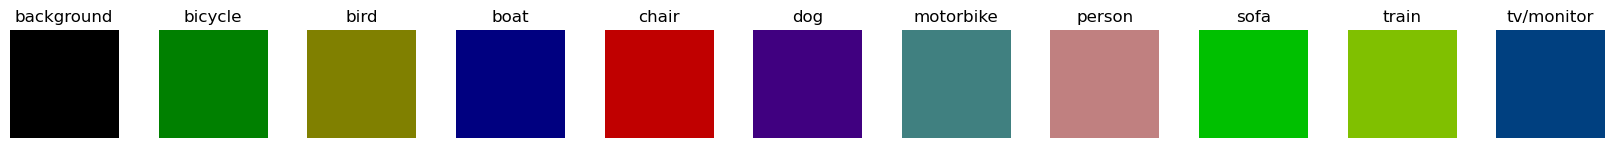

In [118]:
lab_ids = []
for k, v in all_preds.items():
    pred_ids = np.unique(np.stack(v, axis=0))
    pred_ids = [i for i in pred_ids if i != -1]
    lab_ids.extend(pred_ids)
lab_ids = np.unique(lab_ids)

legend = get_legends(lab_ids, palette, label_id_to_cat, is_voc2012 = args.dataset_name == "voc2012", num_cols=11, show=False)
plt.savefig("legends_voc_qualitative.pdf", bbox_inches='tight')

In [140]:
from matplotlib.backends.backend_pdf import PdfPages

# Assuming you have 'fig' and 'legend_fig' as your two separate figures
# 'fig' is the main figure and 'legend_fig' is the legend figure

# Save the combined figures to a PDF file
with PdfPages('voc2012_qualitative.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')
    pdf.savefig(legend_fig, bbox_inches='tight')

# Display the combined figure (optional)
plt.show()